# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from collections import OrderedDict

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

viewer_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.ToTensor()])

# Create training set and define training dataloader

batch_size = 250

## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms) #viewer_transforms

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms) #viewer_transforms

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        #image = image * 0.5 + 0.5  ## unnormalize images
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
               

Five random samples from training data:
truck


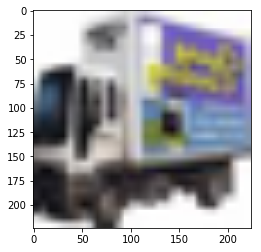

horse


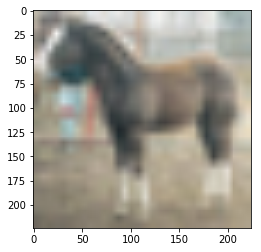

frog


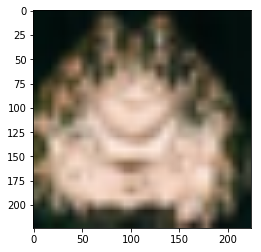

cat


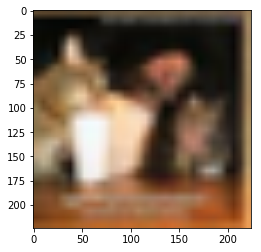

dog


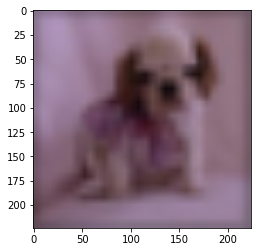

Five random samples from testing data:
cat


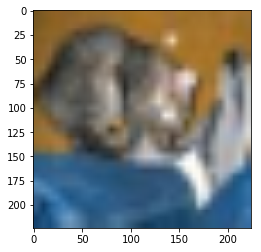

ship


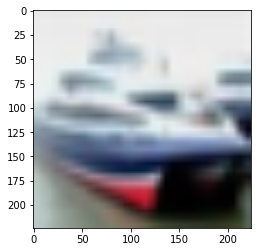

ship


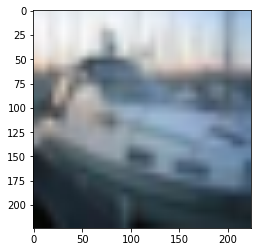

plane


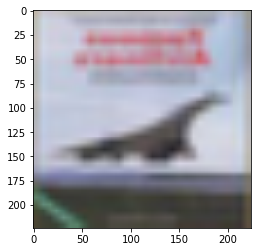

frog


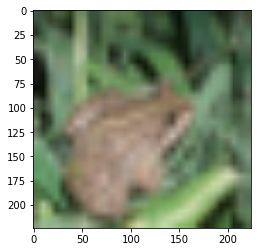

In [4]:
# Explore data
## YOUR CODE HERE ##
print('Five random samples from training data:')
show5(trainloader)
print('Five random samples from testing data:')
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
# load densenet 121 with pretained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Build a new classifier on the top of the convolutional layers
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 524)),
                          ('relu', nn.ReLU()),
                          ('do', nn.Dropout(p=0.3)),
                          ('fc3', nn.Linear(524, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Let us show the model new arquitecture
model.classifier = classifier
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105151304.73it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE ##

model.to(device)

epochs = 2
steps = 0
running_loss = 0
print_every = 30
train_losses = []
val_losses = []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            train_losses.append(loss.item())
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    val_losses.append(batch_loss.item())
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 1.308.. Test loss: 0.831.. Test accuracy: 0.708
Epoch 1/2.. Train loss: 0.728.. Test loss: 0.679.. Test accuracy: 0.769
Epoch 1/2.. Train loss: 0.649.. Test loss: 0.617.. Test accuracy: 0.787
Epoch 1/2.. Train loss: 0.610.. Test loss: 0.605.. Test accuracy: 0.790
Epoch 1/2.. Train loss: 0.603.. Test loss: 0.609.. Test accuracy: 0.791
Epoch 1/2.. Train loss: 0.574.. Test loss: 0.593.. Test accuracy: 0.795
Epoch 2/2.. Train loss: 0.505.. Test loss: 0.552.. Test accuracy: 0.814
Epoch 2/2.. Train loss: 0.303.. Test loss: 0.576.. Test accuracy: 0.813
Epoch 2/2.. Train loss: 0.323.. Test loss: 0.587.. Test accuracy: 0.811
Epoch 2/2.. Train loss: 0.363.. Test loss: 0.601.. Test accuracy: 0.805
Epoch 2/2.. Train loss: 0.348.. Test loss: 0.582.. Test accuracy: 0.812
Epoch 2/2.. Train loss: 0.338.. Test loss: 0.616.. Test accuracy: 0.805
Epoch 2/2.. Train loss: 0.335.. Test loss: 0.588.. Test accuracy: 0.814


Plot the training loss (and validation loss/accuracy, if recorded).

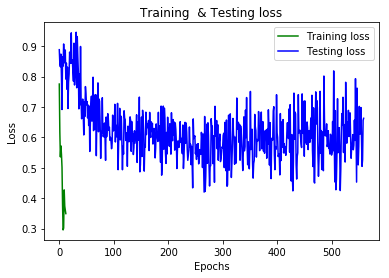

In [16]:
## YOUR CODE HERE ##
import matplotlib.pyplot as plt

#plt.figure(figsize=(10,5))
#plt.title("Training and Validation Loss")
#plt.plot(val_losses,label="val")
#plt.plot(train_losses,label="train")
#plt.xlabel("iterations")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()

plt.plot(train_losses, 'g', label='Training loss')
plt.plot(val_losses, 'b', label='Testing loss')
plt.title('Training  & Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##
test_loss = 0
accuracy = 0
model.to(device)

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()
        val_losses.append(batch_loss.item())
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(testloader):.3f}")

Test accuracy: 0.801


## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
## YOUR CODE HERE ##


checkpoint = {'input_size': 150528,
              '': ,
              '': ,
              'output_size': 10,
              'classifier': model.classifier,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The accuracy is above the 70% accuracy only applying two techniques, transfer learning and data augmentation.

It seems clear that the result could be improved by creating a better model structure, so the recommendation is to create something build in the house.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model? It is a 10% better in acccuracy.
* How does it compare to the far more advanced solutions in the literature? Obviously, it is far from the 99% state of the art of the literature, but it is a good starting point, considering only basic techniques has been aplied.
* What did you do to get the accuracy you achieved? To apply the two basic and most important techniques explained in the course, i.e., data augmentation and transfer learning.
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it? I would try to add a couple of convolutional layers at the top of the freeze vgg16 model. If that didn't improve the result, I would have to see what type of error I am doing (bias or variance) and what other state of the art techniques It is interesting to apply (state of the art research).



**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).